In [1]:
# ------------------------------------------------------
# 1. Imports and setup
# ------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (accuracy_score, log_loss, classification_report, 
                             confusion_matrix, roc_auc_score, roc_curve, brier_score_loss)
from sklearn.calibration import calibration_curve
import xgboost as xgb
import statsmodels.api as sm
import statsmodels.formula.api as smf

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

print("Libraries loaded. Ready for ML.")

Libraries loaded. Ready for ML.


In [2]:
# ------------------------------------------------------
# 2. Load data and feature engineering
# ------------------------------------------------------
# 1. Load master dataset
df = pd.read_csv('../data-processed/win_prob_training_data.csv')

# 2. Define full list (for hypothesis testing later)
all_features = [
    'pre_match_rank_diff', 'squad_age_diff', 'kickoff_hour',
    'temperature', 'apparent_temp', 'humidity', 'wind_speed',
    'score_diff', 'red_diff', 'yellow_diff', 'home_subs', 'away_subs', 
    'time_remaining',
    # The "Future" variables (safe for Analysis, invalid for ML)
    'total_shot_diff', 'total_sot_diff', 'foul_diff', 'hPossession',
    'is_extra_time', 'is_penalty_shootout'
]

target = 'target_home_win'

# 3. Define the ML features
# Specifically exclude future variables here to prevent data leakage
ml_features = [
    # Static context
    'pre_match_rank_diff', 
    'squad_age_diff', 
    'kickoff_hour',
    'temperature', 'apparent_temp', 'humidity', 'wind_speed',
    
    # Dynamic game state
    'score_diff', 
    'red_diff', 
    'yellow_diff', 
    'home_subs', 
    'away_subs',
    'time_remaining'
]

# 4. Drop rows with missing values
# Drop NaNs based on all features to ensure the hypothesis tests don't crash later
print(f"Original shape: {df.shape}")
df_clean = df.dropna(subset=all_features + [target])
print(f"Clean shape: {df_clean.shape}")

# 5. Preview correlation (using safe features only to see predictive power)
print("\n--- Correlation (Safe Features only) ---")
print(df_clean[ml_features + [target]].corr()[target].sort_values(ascending=False))

Original shape: (2304, 25)
Clean shape: (2304, 25)

--- Correlation (Safe Features only) ---
target_home_win        1.000000e+00
score_diff             5.384097e-01
pre_match_rank_diff    3.235333e-01
red_diff               1.878932e-01
yellow_diff            1.423086e-01
away_subs              8.609674e-02
temperature            4.193927e-02
apparent_temp          3.912882e-02
wind_speed             3.462331e-02
humidity               1.392194e-02
time_remaining         3.441095e-17
home_subs             -1.770946e-02
squad_age_diff        -2.887422e-02
kickoff_hour          -4.077497e-02
Name: target_home_win, dtype: float64


In [3]:
# ------------------------------------------------------
# 3. Leakage-proof split
# ------------------------------------------------------
# 1. Get unique matches
match_ids = df_clean['match_id'].unique()
train_ids, test_ids = train_test_split(match_ids, test_size=0.2, random_state=42)

# 2. Filter df based on these IDs
train_df = df_clean[df_clean['match_id'].isin(train_ids)]
test_df = df_clean[df_clean['match_id'].isin(test_ids)]

# 3. Define X and y using only safe ML List
# To ensure model never sees 'total_shots' or 'is_extra_time'
X_train = train_df[ml_features] 
y_train = train_df[target]

X_test = test_df[ml_features] 
y_test = test_df[target]

print(f"Training on {len(train_ids)} matches ({len(X_train)} rows)")
print(f"Testing on {len(test_ids)} matches ({len(X_test)} rows)")
print(f"Features used for training: {len(X_train.columns)}")

Training on 307 matches (1842 rows)
Testing on 77 matches (462 rows)
Features used for training: 13


In [4]:
# ------------------------------------------------------
# 4. Model training
# ------------------------------------------------------
# Dictionary to store  models
models = {}

# --- 1. Logistic regression (baseline) ---
# Requires scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
models['Logistic Regression'] = log_reg

# --- 2. K-nearest neighbours ---
# Must use scaled data
knn = KNeighborsClassifier(n_neighbors=15) # Safe starting point to reduce noise
knn.fit(X_train_scaled, y_train)
models['KNN'] = knn

# --- 3. Decision tree ---
# Often overfits, good for "white box" explainability
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
models['Decision Tree'] = dt

# --- 4. Random forest ---
rf_model = RandomForestClassifier(
    n_estimators=200, 
    max_depth=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
models['Random Forest'] = rf_model

# --- 5. Gradient boosting ---
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)
gb_model.fit(X_train, y_train)
models['Gradient Boosting'] = gb_model

# --- 6. XGBoost ---
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)
models['XGBoost'] = xgb_model

print(f"Trained {len(models)} models successfully.")

Trained 6 models successfully.


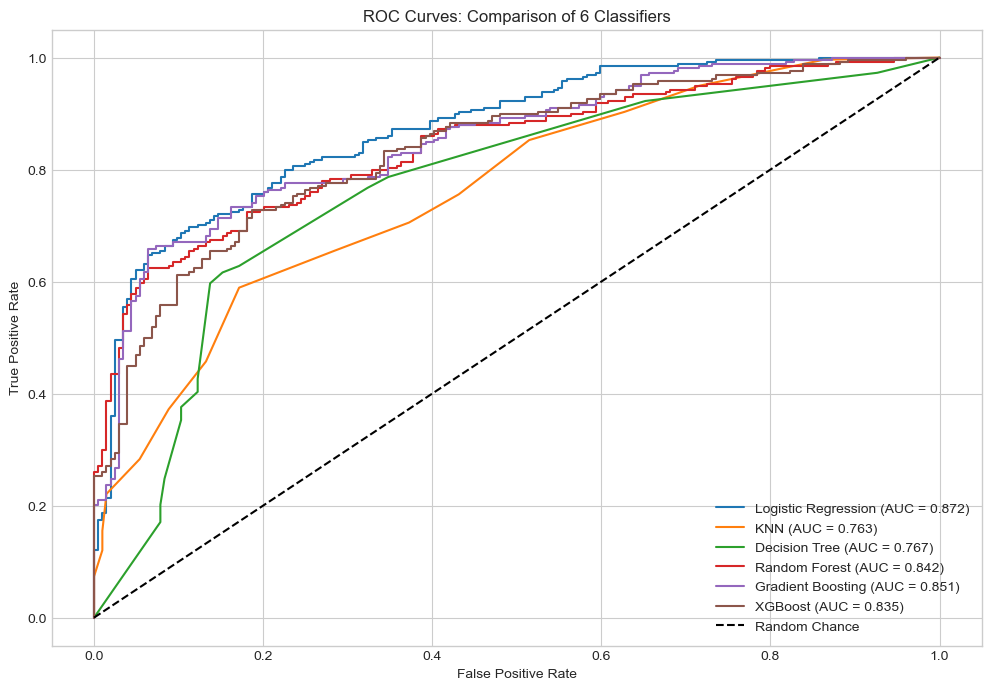


--- Model Performance Metrics ---
                 Model  Accuracy  Log Loss     AUC  Brier Score
0  Logistic Regression    0.7727    0.4769  0.8724       0.1568
4    Gradient Boosting    0.7727    0.5143  0.8510       0.1693
3        Random Forest    0.7532    0.5305  0.8415       0.1753
5              XGBoost    0.7446    0.6110  0.8353       0.1903
1                  KNN    0.6948    0.6966  0.7627       0.2168
2        Decision Tree    0.7143    2.3639  0.7675       0.2299


In [5]:
# ------------------------------------------------------
# 5. Comprehensive evaluation
# ------------------------------------------------------
results = []
plt.figure(figsize=(12, 8))

for name, model in models.items():
    # A. Handle scaling logic
    # LogReg and KNN need scaled data; trees do not
    if name in ['Logistic Regression', 'KNN']:
        X_val = X_test_scaled
    else:
        X_val = X_test
        
    # B. Predictions
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1]
    
    # C. Metrics
    acc = accuracy_score(y_test, y_pred)
    ll = log_loss(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    brier = brier_score_loss(y_test, y_prob)
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Log Loss': ll, 
        'AUC': auc,
        'Brier Score': brier
    })
    
    # D. Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

# Baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Comparison of 6 Classifiers')
plt.legend(loc='lower right')
plt.show()

# Display metrics table sorted by Brier score (best to worst)
metrics_df = pd.DataFrame(results).sort_values(by='Brier Score', ascending=True)
print("\n--- Model Performance Metrics ---")
print(metrics_df.round(4))

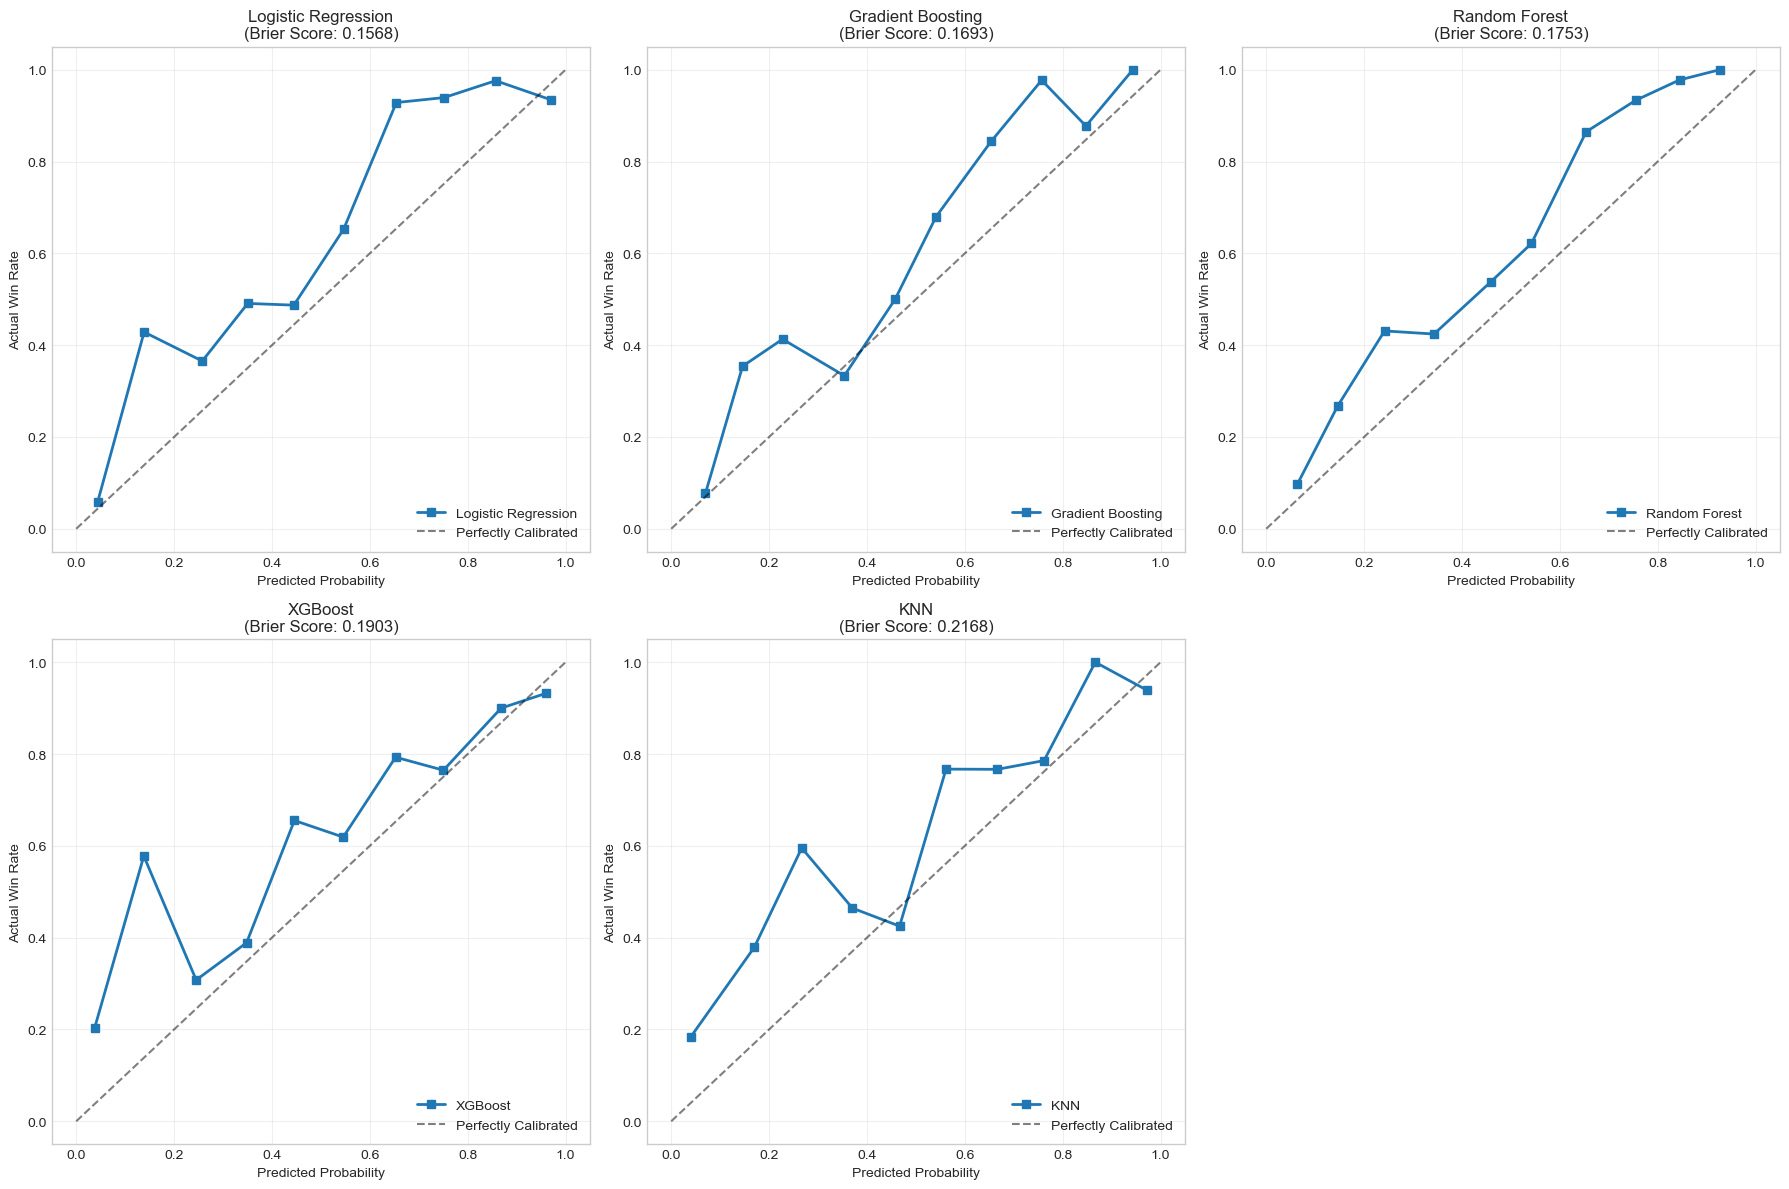

Interpretation Guide:
- If the blue line is BELOW the dotted line, the model is OVER-CONFIDENT (predicting too high win prob).
- If the blue line is ABOVE the dotted line, the model is UNDER-CONFIDENT (too conservative).
- Logistic Regression should be closest to the dotted line (lowest Brier score).


In [6]:
# ------------------------------------------------------
# 6. Probability calibration analysis
# ------------------------------------------------------
import matplotlib.gridspec as gridspec

plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(2, 3)

# List of models to plot (skip decision tree as it doesn't output smooth probs)
models_to_plot = ['Logistic Regression', 'Gradient Boosting', 'Random Forest', 'XGBoost', 'KNN']

for i, name in enumerate(models_to_plot):
    ax = plt.subplot(gs[i])
    model = models[name]
    
    # Handle scaling logic
    if name in ['Logistic Regression', 'KNN']:
        X_val = X_test_scaled
    else:
        X_val = X_test
        
    # Get probabilities
    prob_pos = model.predict_proba(X_val)[:, 1]
    
    # Calculate calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
    
    # Plot
    ax.plot(mean_predicted_value, fraction_of_positives, "s-", linewidth=2, color='tab:blue', label=name)
    ax.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated", alpha=0.5)
    
    # Metrics for title
    brier = brier_score_loss(y_test, prob_pos)
    
    ax.set_ylabel("Actual Win Rate")
    ax.set_xlabel("Predicted Probability")
    ax.set_title(f"{name}\n(Brier Score: {brier:.4f})")
    ax.legend(loc="lower right")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Interpretation Guide:")
print("- If the blue line is BELOW the dotted line, the model is OVER-CONFIDENT (predicting too high win prob).")
print("- If the blue line is ABOVE the dotted line, the model is UNDER-CONFIDENT (too conservative).")
print("- Logistic Regression should be closest to the dotted line (lowest Brier score).")